# **Check GPU**

In [1]:
PROJECT_NAME = 'PCB'

In [2]:
!nvidia-smi

Tue Sep  3 08:16:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Requirements**

In [3]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 770.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 19.4 MB/s eta 0:00:00


# **Roboflow Dataset**

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="4LkXLK8ZSbLkfVFlFbMf")
project = rf.workspace("cnn-pcb-defect-detection").project("pcb-defect-detection-ultra")
version = project.version(6)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.86, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to PCB-DEFECT-DETECTION-ULTRA-6 in yolov8:: 100%|██████████| 18040/18040 [00:03<00:00, 5058.63it/s]


# **LIBRARIES**

In [5]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

# **DEPENDENCIES**

In [6]:
HOME = os.getcwd()
HOME

'/content'

In [17]:
dataset_dir = f'{HOME}/PCB-DEFECT-DETECTION-ULTRA-6/'
models_dir = f'{HOME}/models'
os.makedirs(models_dir, exist_ok=True)

# **Visualize Samples**

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

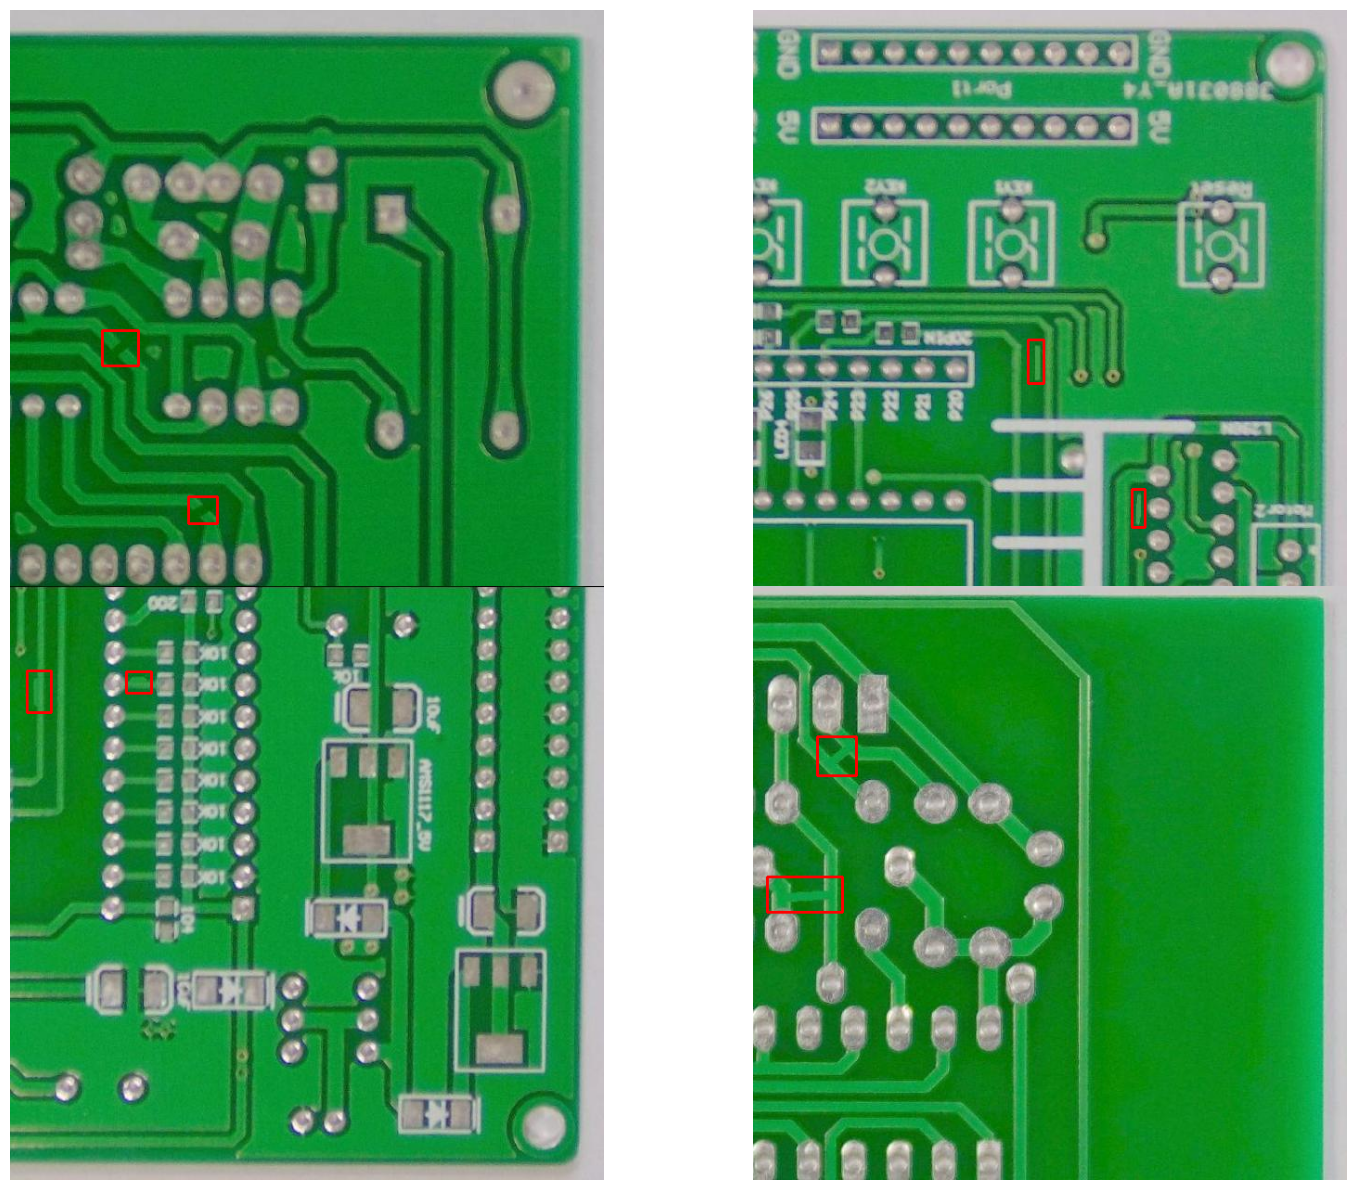

In [18]:
# Visualize a few training images.
plot(
    image_paths=f'{dataset_dir}/train/images/',
    label_paths=f'{dataset_dir}/train/labels/',
    num_samples=4,
)

# **YOLOv8**

In [12]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.4/78.2 GB disk)


In [13]:
modelS = YOLO(f"{models_dir}/yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 258MB/s]


WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 38.1ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 38.7ms
Speed: 6.2ms preprocess, 38.4ms inference, 373.9ms postprocess per image at shape (1, 3, 384, 640)


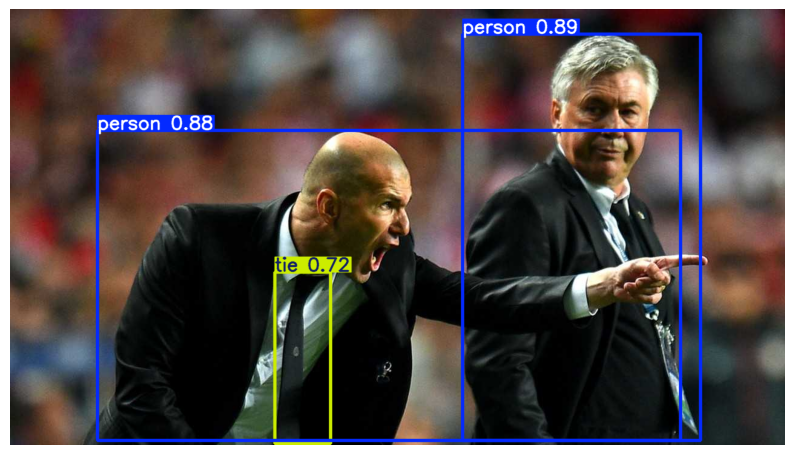

In [14]:
TEST_IMAGE_PATH = f'{HOME}/test_image.jpg'
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)
# TEST_IMAGE = cv2.resize(TEST_IMAGE, (640, 640))
CHECK_TEST_RESULT = modelS.predict(source=TEST_IMAGE, conf=0.5, save=False, imgsz=640)

plt.figure(figsize=(10, 10))
for result in CHECK_TEST_RESULT:
    plotted_image = result.plot()
    plotted_image_rgb = cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(plotted_image_rgb)
    plt.axis('off')
plt.show()

# **Create YAML file**

In [20]:
yamlPath = f'{dataset_dir}/data.yaml'

In [21]:
yamlContent = f"""
# DataURL: https://universe.roboflow.com/cnn-pcb-defect-detection/pcb-defect-detection-ultra/dataset/6
path: '{dataset_dir}'
test: 'test/images'
train: 'train/images'
val: 'valid/images'

# class names
nc: 6
names:
  0: 'MissingHole'
  1: 'MouseBite'
  2: 'OpenCircuit'
  3: 'ShortCircuit'
  4: 'Spur'
  5: 'SpuriousCooper'
"""

with open(f'{yamlPath}', 'w') as yaml:
    yaml.write(yamlContent)

# **Parameters**

In [23]:
EPOCHS = 30
IMAGE_SIZE = 960
BATCH = 24
NAME = f'yolov8s_{PROJECT_NAME}'

# **Train**

In [24]:
# Train Model
modelS.train(
    data=yamlPath,            # Path to the dataset configuration file
    epochs=EPOCHS,            # Number of epochs to train for
    imgsz=IMAGE_SIZE,         # Image size
    batch=BATCH,              # Batch size
    name=NAME                 # Name of the training run
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/models/yolov8s.pt, data=/content/PCB-DEFECT-DETECTION-ULTRA-6//data.yaml, epochs=30, time=None, patience=100, batch=24, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_PCB, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

100%|██████████| 755k/755k [00:00<00:00, 29.0MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 124MB/s]


AMP: checks passed ✅


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
train: Scanning /content/PCB-DEFECT-DETECTION-ULTRA-6/train/labels... 6333 images, 1 backgrounds, 0 corrupt: 100%|██████████| 6333/6333 [00:03<00:00, 1975.62it/s]


train: New cache created: /content/PCB-DEFECT-DETECTION-ULTRA-6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/PCB-DEFECT-DETECTION-ULTRA-6/valid/labels... 1778 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1778/1778 [00:02<00:00, 607.33it/s]


val: New cache created: /content/PCB-DEFECT-DETECTION-ULTRA-6/valid/labels.cache
Plotting labels to runs/detect/yolov8s_PCB/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_PCB
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      12.5G      2.041       4.68      1.723         45        960: 100%|██████████| 264/264 [04:43<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]


                   all       1778       3656      0.906      0.791      0.889      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.2G      1.305      1.465      1.114         70        960: 100%|██████████| 264/264 [04:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.13it/s]

                   all       1778       3656      0.957      0.916      0.962      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.2G      1.209      0.963      1.077         56        960: 100%|██████████| 264/264 [04:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


                   all       1778       3656      0.963      0.924      0.968      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.1G      1.144     0.7593      1.047         52        960: 100%|██████████| 264/264 [04:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]

                   all       1778       3656      0.972      0.961      0.984      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.1G      1.105     0.6886       1.03         55        960: 100%|██████████| 264/264 [04:34<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


                   all       1778       3656      0.969       0.96      0.985      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      12.2G      1.075     0.6363      1.014         65        960: 100%|██████████| 264/264 [04:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]

                   all       1778       3656      0.977      0.971      0.988      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.2G      1.061     0.6102      1.007         52        960: 100%|██████████| 264/264 [04:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.972      0.975      0.988      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.2G      1.033     0.5815      1.002         63        960: 100%|██████████| 264/264 [04:31<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.972      0.981      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.1G      1.023     0.5627      1.002         61        960: 100%|██████████| 264/264 [04:35<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]

                   all       1778       3656      0.974      0.983      0.988       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      12.2G      1.001     0.5447     0.9843         64        960: 100%|██████████| 264/264 [04:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.19it/s]

                   all       1778       3656      0.974      0.983      0.988      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.2G     0.9989     0.5451     0.9873         69        960: 100%|██████████| 264/264 [04:41<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


                   all       1778       3656      0.974      0.983       0.99      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.1G     0.9811      0.527     0.9757         58        960: 100%|██████████| 264/264 [04:36<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]

                   all       1778       3656      0.977      0.984      0.989      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.1G      0.964     0.5192     0.9677         66        960: 100%|██████████| 264/264 [04:35<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


                   all       1778       3656      0.976      0.983       0.99      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.1G     0.9553     0.5031     0.9687         66        960: 100%|██████████| 264/264 [04:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]

                   all       1778       3656      0.972      0.983       0.99      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      12.1G     0.9544     0.4925     0.9674         63        960: 100%|██████████| 264/264 [04:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.973      0.987       0.99      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.1G     0.9445     0.4939     0.9646         61        960: 100%|██████████| 264/264 [04:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


                   all       1778       3656      0.973      0.986      0.991      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.1G     0.9329     0.4804     0.9574         49        960: 100%|██████████| 264/264 [04:35<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.979      0.981      0.991      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      12.1G     0.9179     0.4746     0.9545         53        960: 100%|██████████| 264/264 [04:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.15it/s]

                   all       1778       3656      0.974      0.987      0.991      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.1G      0.909     0.4707     0.9455         65        960: 100%|██████████| 264/264 [04:33<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


                   all       1778       3656      0.979      0.983      0.991      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      12.1G     0.9039     0.4663     0.9493         50        960: 100%|██████████| 264/264 [04:33<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]

                   all       1778       3656      0.977      0.984      0.991      0.767


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      12.1G     0.8856       0.43     0.9647         35        960: 100%|██████████| 264/264 [04:30<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.978      0.985      0.991      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      12.1G     0.8702     0.4224     0.9593         39        960: 100%|██████████| 264/264 [04:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.14it/s]

                   all       1778       3656      0.978      0.986      0.991      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      12.1G     0.8618     0.4169     0.9556         48        960: 100%|██████████| 264/264 [04:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


                   all       1778       3656      0.977      0.985      0.991      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      12.1G     0.8465     0.4052     0.9493         38        960: 100%|██████████| 264/264 [04:18<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.975      0.989      0.992      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      12.1G     0.8391     0.4038     0.9416         29        960: 100%|██████████| 264/264 [04:19<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.977      0.985      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      12.1G     0.8281     0.3959     0.9371         43        960: 100%|██████████| 264/264 [04:17<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.15it/s]

                   all       1778       3656      0.975      0.991      0.992      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      12.1G     0.8202     0.3922     0.9347         42        960: 100%|██████████| 264/264 [04:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


                   all       1778       3656      0.978      0.988      0.992      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      12.1G     0.8122     0.3879     0.9341         44        960: 100%|██████████| 264/264 [04:19<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


                   all       1778       3656      0.976      0.989      0.992      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      12.1G     0.8011     0.3796     0.9295         34        960: 100%|██████████| 264/264 [04:16<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

                   all       1778       3656      0.977      0.987      0.992       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      12.1G     0.7907     0.3784     0.9259         38        960: 100%|██████████| 264/264 [04:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:33<00:00,  1.15it/s]

                   all       1778       3656      0.979      0.986      0.992       0.79



30 epochs completed in 2.541 hours.
Optimizer stripped from runs/detect/yolov8s_PCB/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/yolov8s_PCB/weights/best.pt, 22.6MB

Validating runs/detect/yolov8s_PCB/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:40<00:00,  1.05s/it]


                   all       1778       3656      0.979      0.986      0.992       0.79
           MissingHole        304        610      0.987      0.997      0.994      0.853
             MouseBite        317        630      0.973      0.989      0.991       0.75
           OpenCircuit        299        585      0.981      0.978      0.993      0.769
          ShortCircuit        283        575      0.983       0.99      0.992      0.791
                  Spur        294        603      0.965      0.972      0.991      0.807
        SpuriousCooper        308        653      0.985      0.991      0.992      0.772
Speed: 0.5ms preprocess, 10.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/yolov8s_PCB


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798cf4a03f40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

# **Validate**

In [25]:
evaluateCARS_Sval = modelS.val(
    data = yamlPath,
    split = 'val',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/PCB-DEFECT-DETECTION-ULTRA-6/valid/labels.cache... 1778 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1778/1778 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


                   all       1778       3656      0.979      0.986      0.992      0.792
           MissingHole        304        610      0.987      0.997      0.994      0.857
             MouseBite        317        630      0.973      0.989      0.991      0.752
           OpenCircuit        299        585      0.981      0.978      0.993      0.771
          ShortCircuit        283        575      0.983       0.99      0.992      0.789
                  Spur        294        603      0.965      0.972      0.991       0.81
        SpuriousCooper        308        653      0.985      0.991      0.992      0.772
Speed: 0.7ms preprocess, 20.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/yolov8s_PCB2


# **Evaluate**

In [33]:
evaluateCARS_Stest = modelS.val(
    data = yamlPath,
    split = 'test',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/PCB-DEFECT-DETECTION-ULTRA-6/test/labels.cache... 903 images, 0 backgrounds, 0 corrupt: 100%|██████████| 903/903 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/PCB-DEFECT-DETECTION-ULTRA-6/test/images/l_light_10_spur_03_4_600_jpg.rf.90c243929203bc8efca3278a2be487b7.jpg: 1 duplicate labels removed



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


                   all        903       1859       0.98      0.996      0.991      0.797
           MissingHole        164        312      0.995          1      0.994      0.857
             MouseBite        149        309      0.987          1      0.993      0.759
           OpenCircuit        135        273      0.978      0.996      0.985      0.744
          ShortCircuit        148        308      0.965      0.992       0.99      0.822
                  Spur        160        325      0.979       0.99      0.994      0.814
        SpuriousCooper        160        332      0.974          1      0.991      0.782
Speed: 0.7ms preprocess, 19.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/yolov8s_PCB4


# **Download**

In [35]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

from IPython.display import FileLink
FileLink(r'runs.zip')

/content/runs.zip

# **PLOTS**

In [28]:
from IPython.display import display, Image
from IPython import display
display.clear_output()

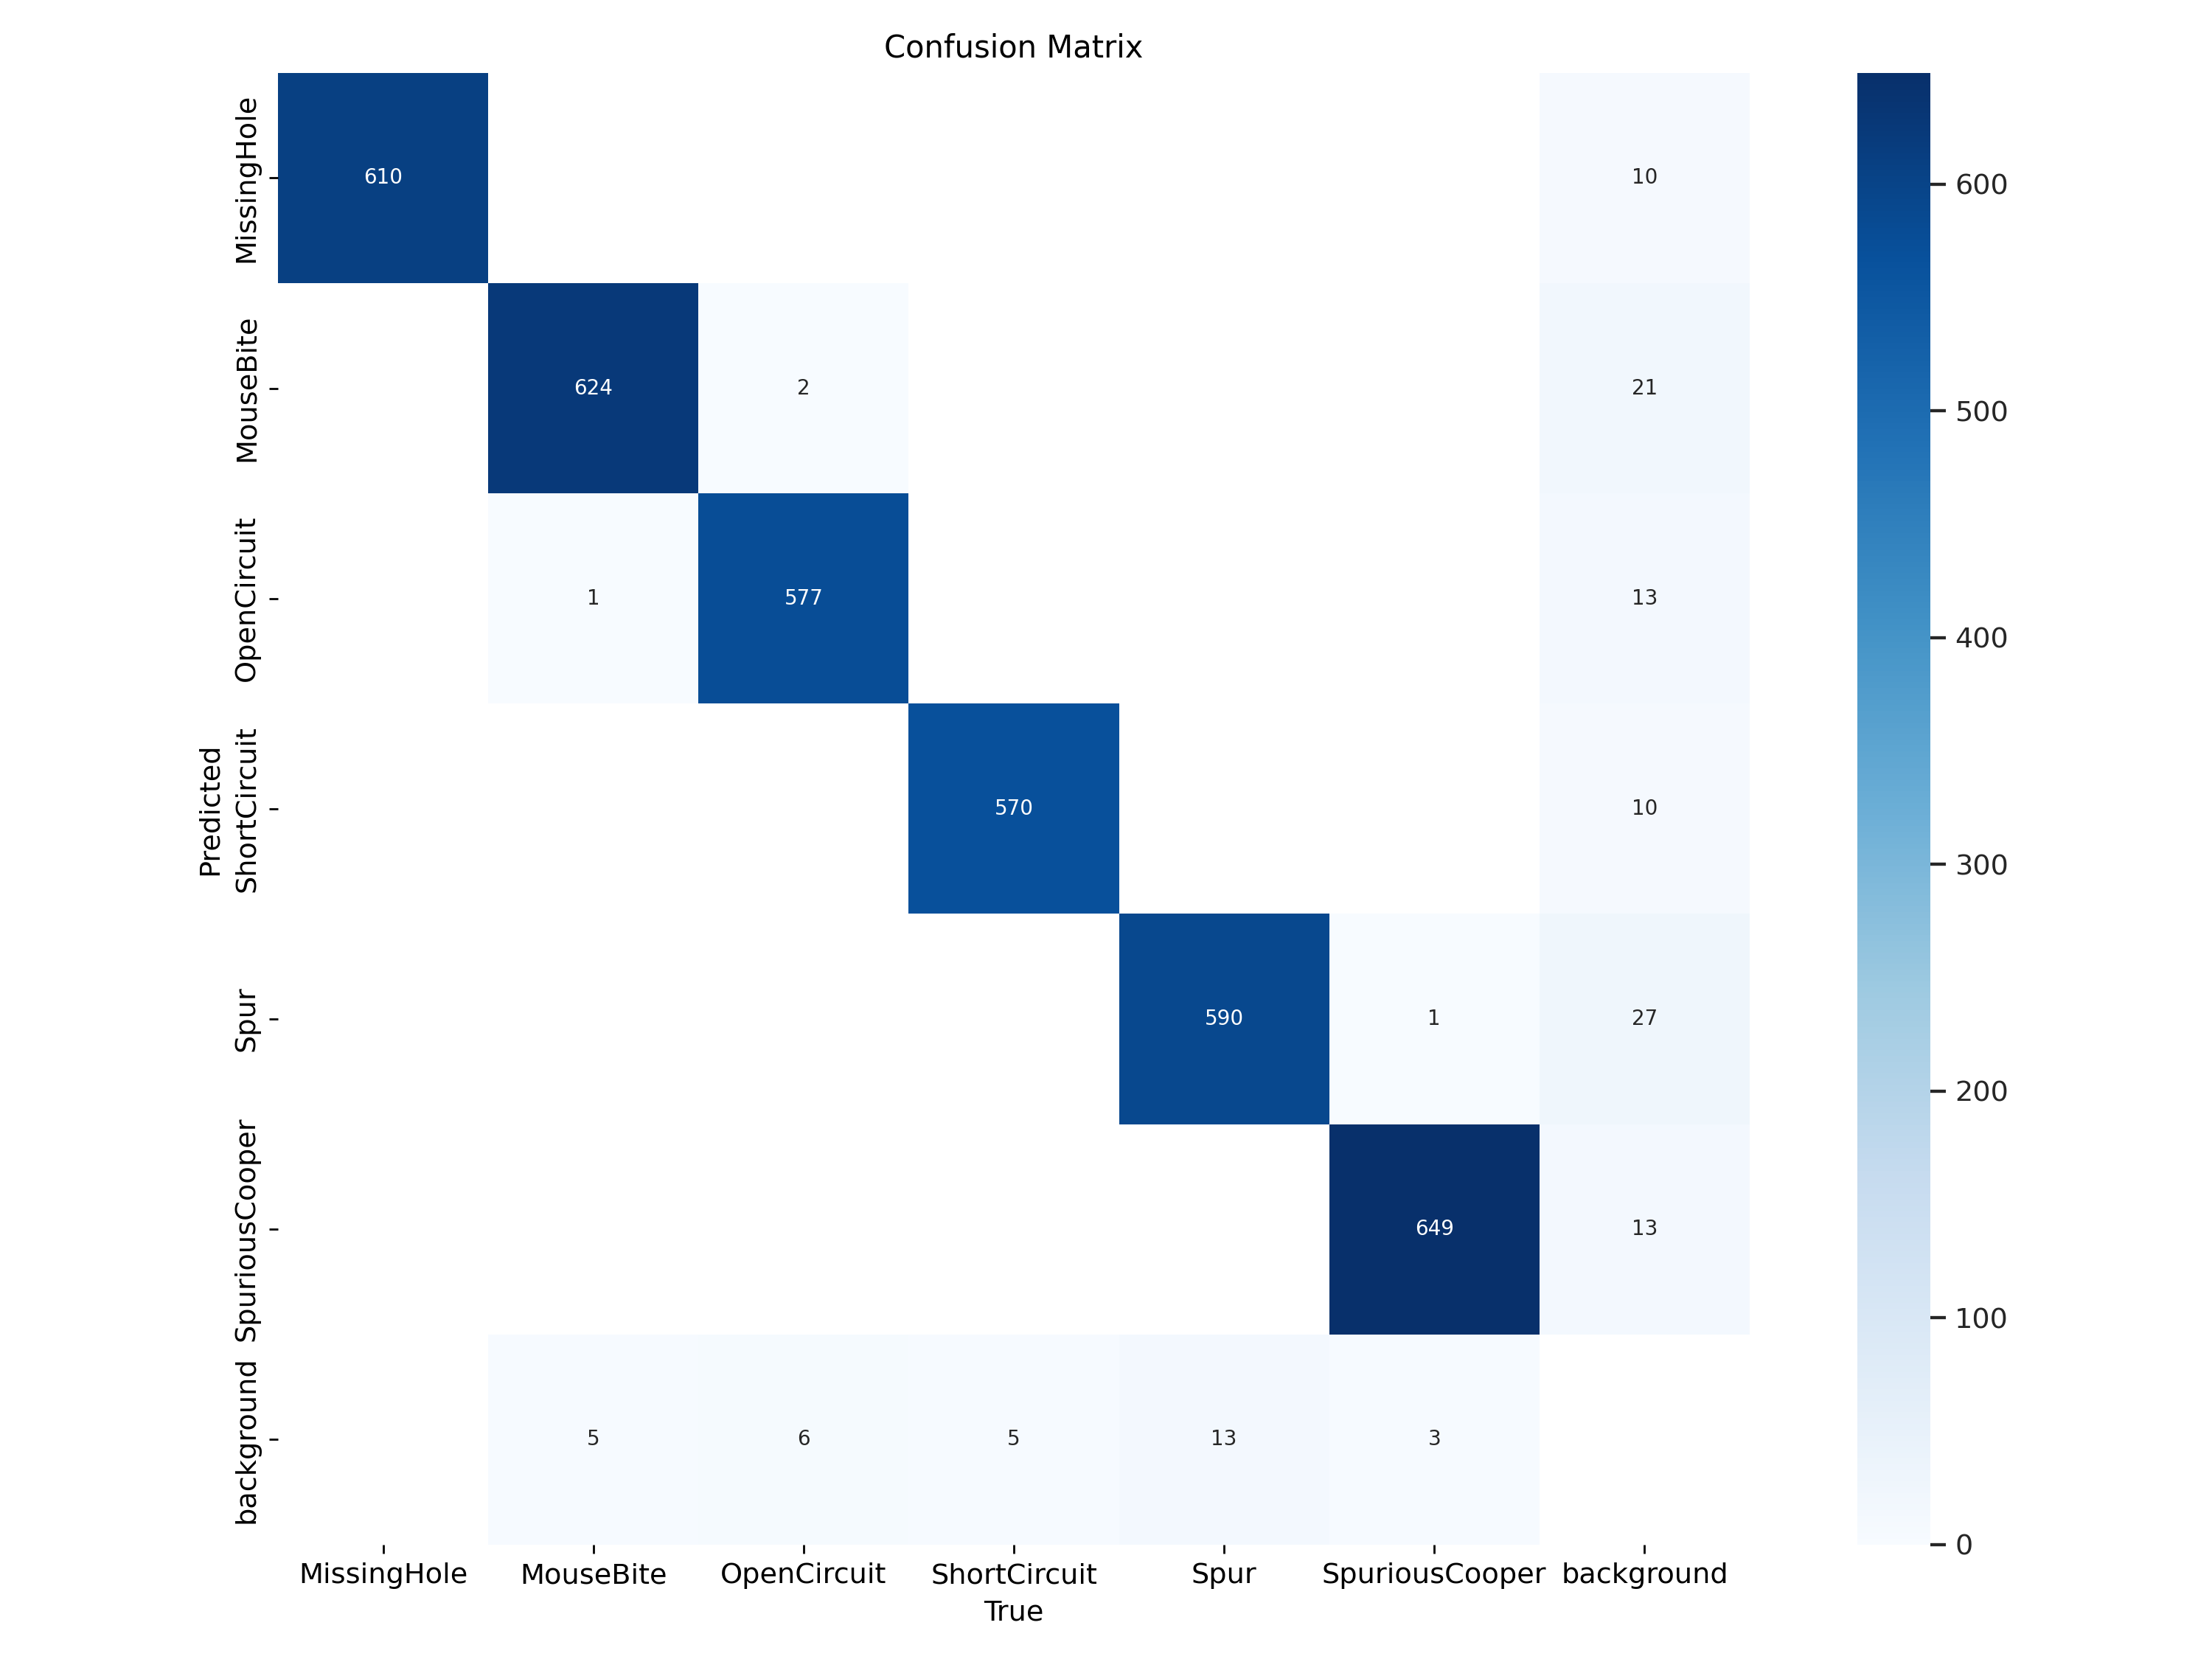

In [29]:
Image(filename=f'{HOME}/runs/detect/{NAME}/confusion_matrix.png', width=600)

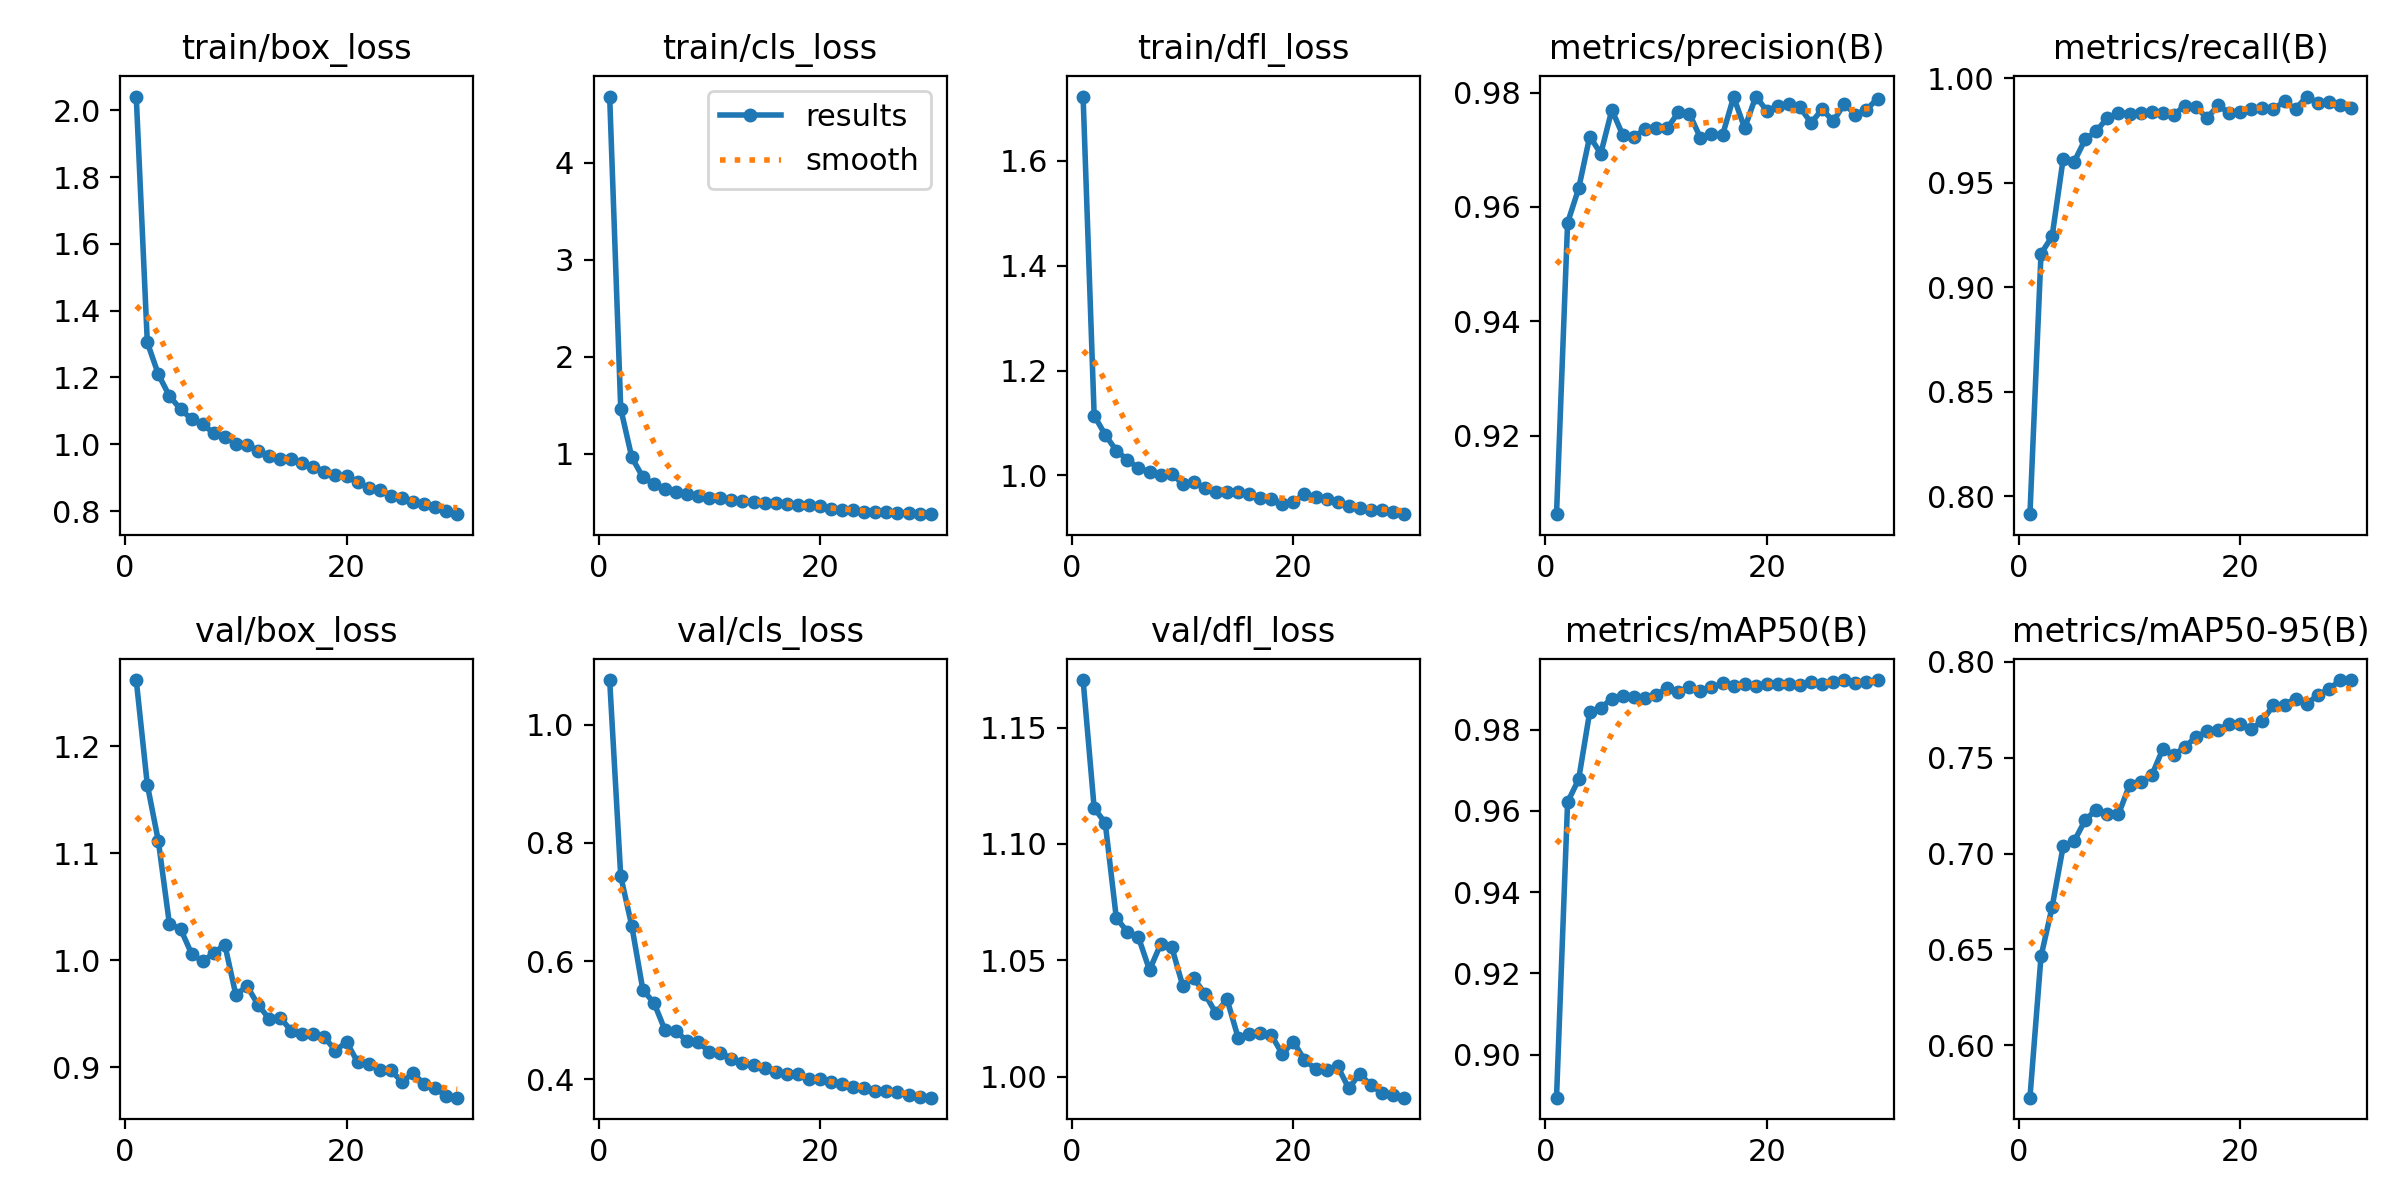

In [30]:
Image(filename=f'{HOME}/runs/detect/{NAME}/results.png', width=600)

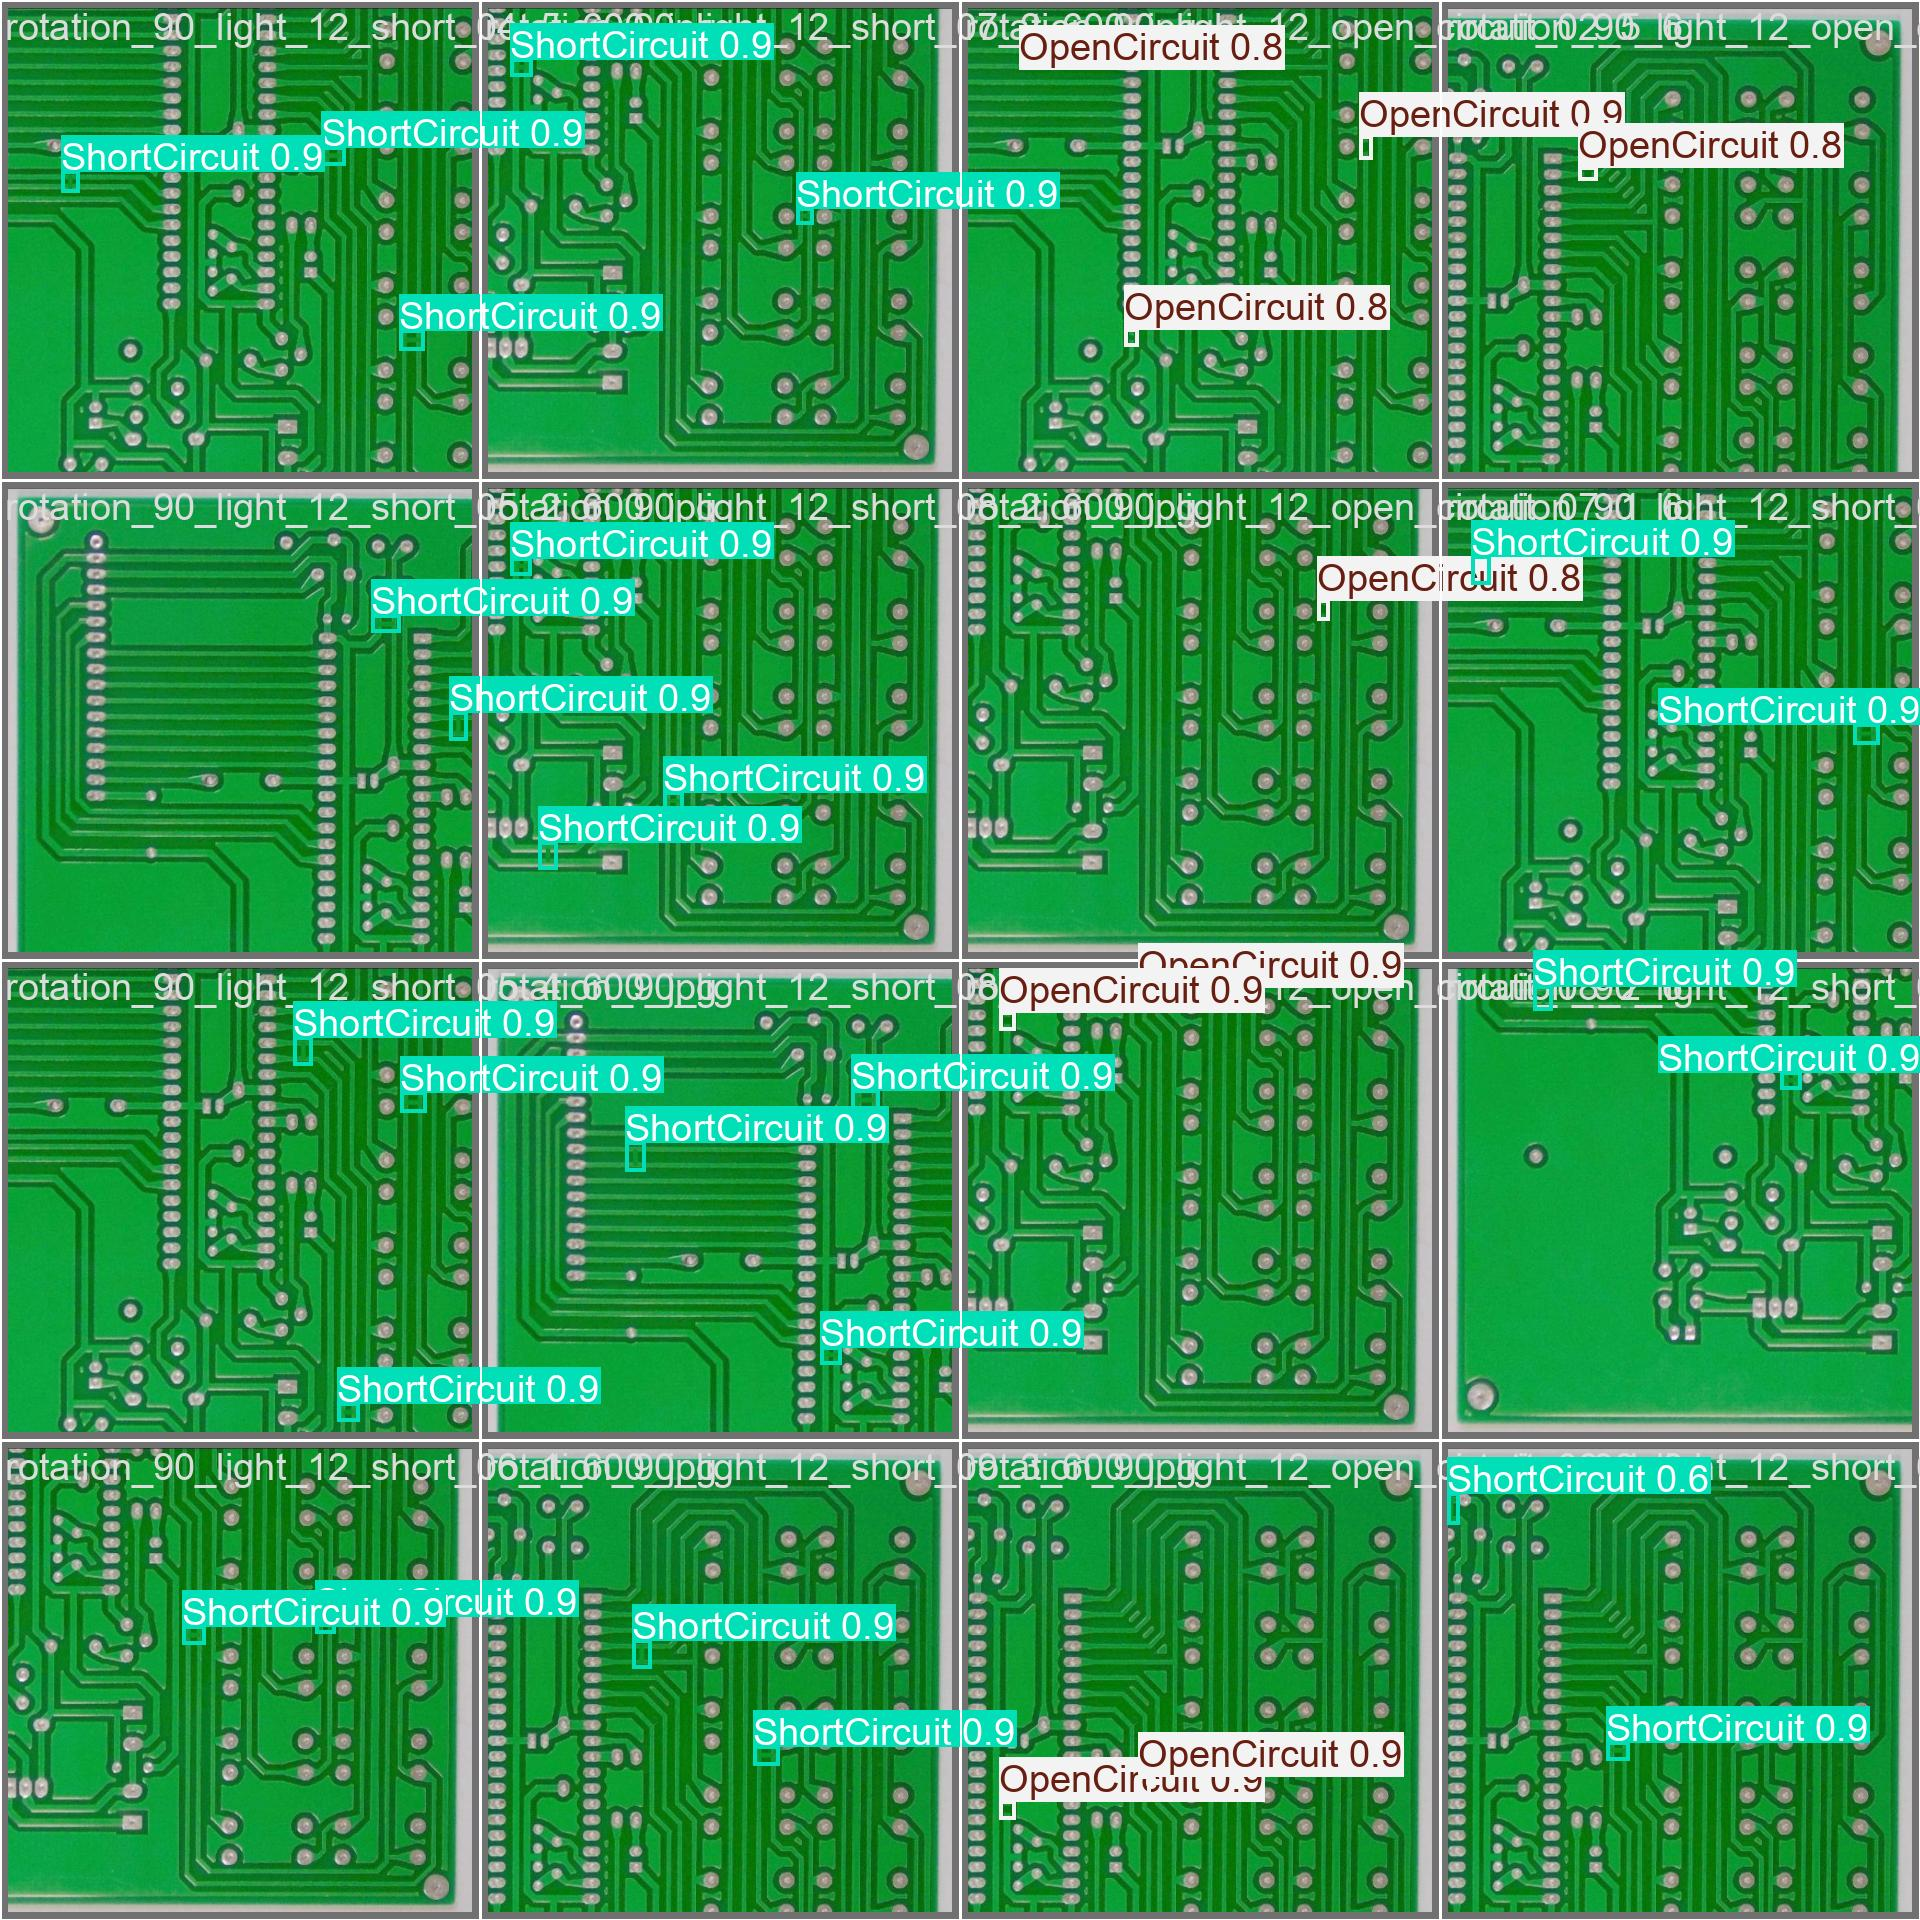

In [31]:
Image(filename=f'{HOME}/runs/detect/{NAME}/val_batch0_pred.jpg', width=600)

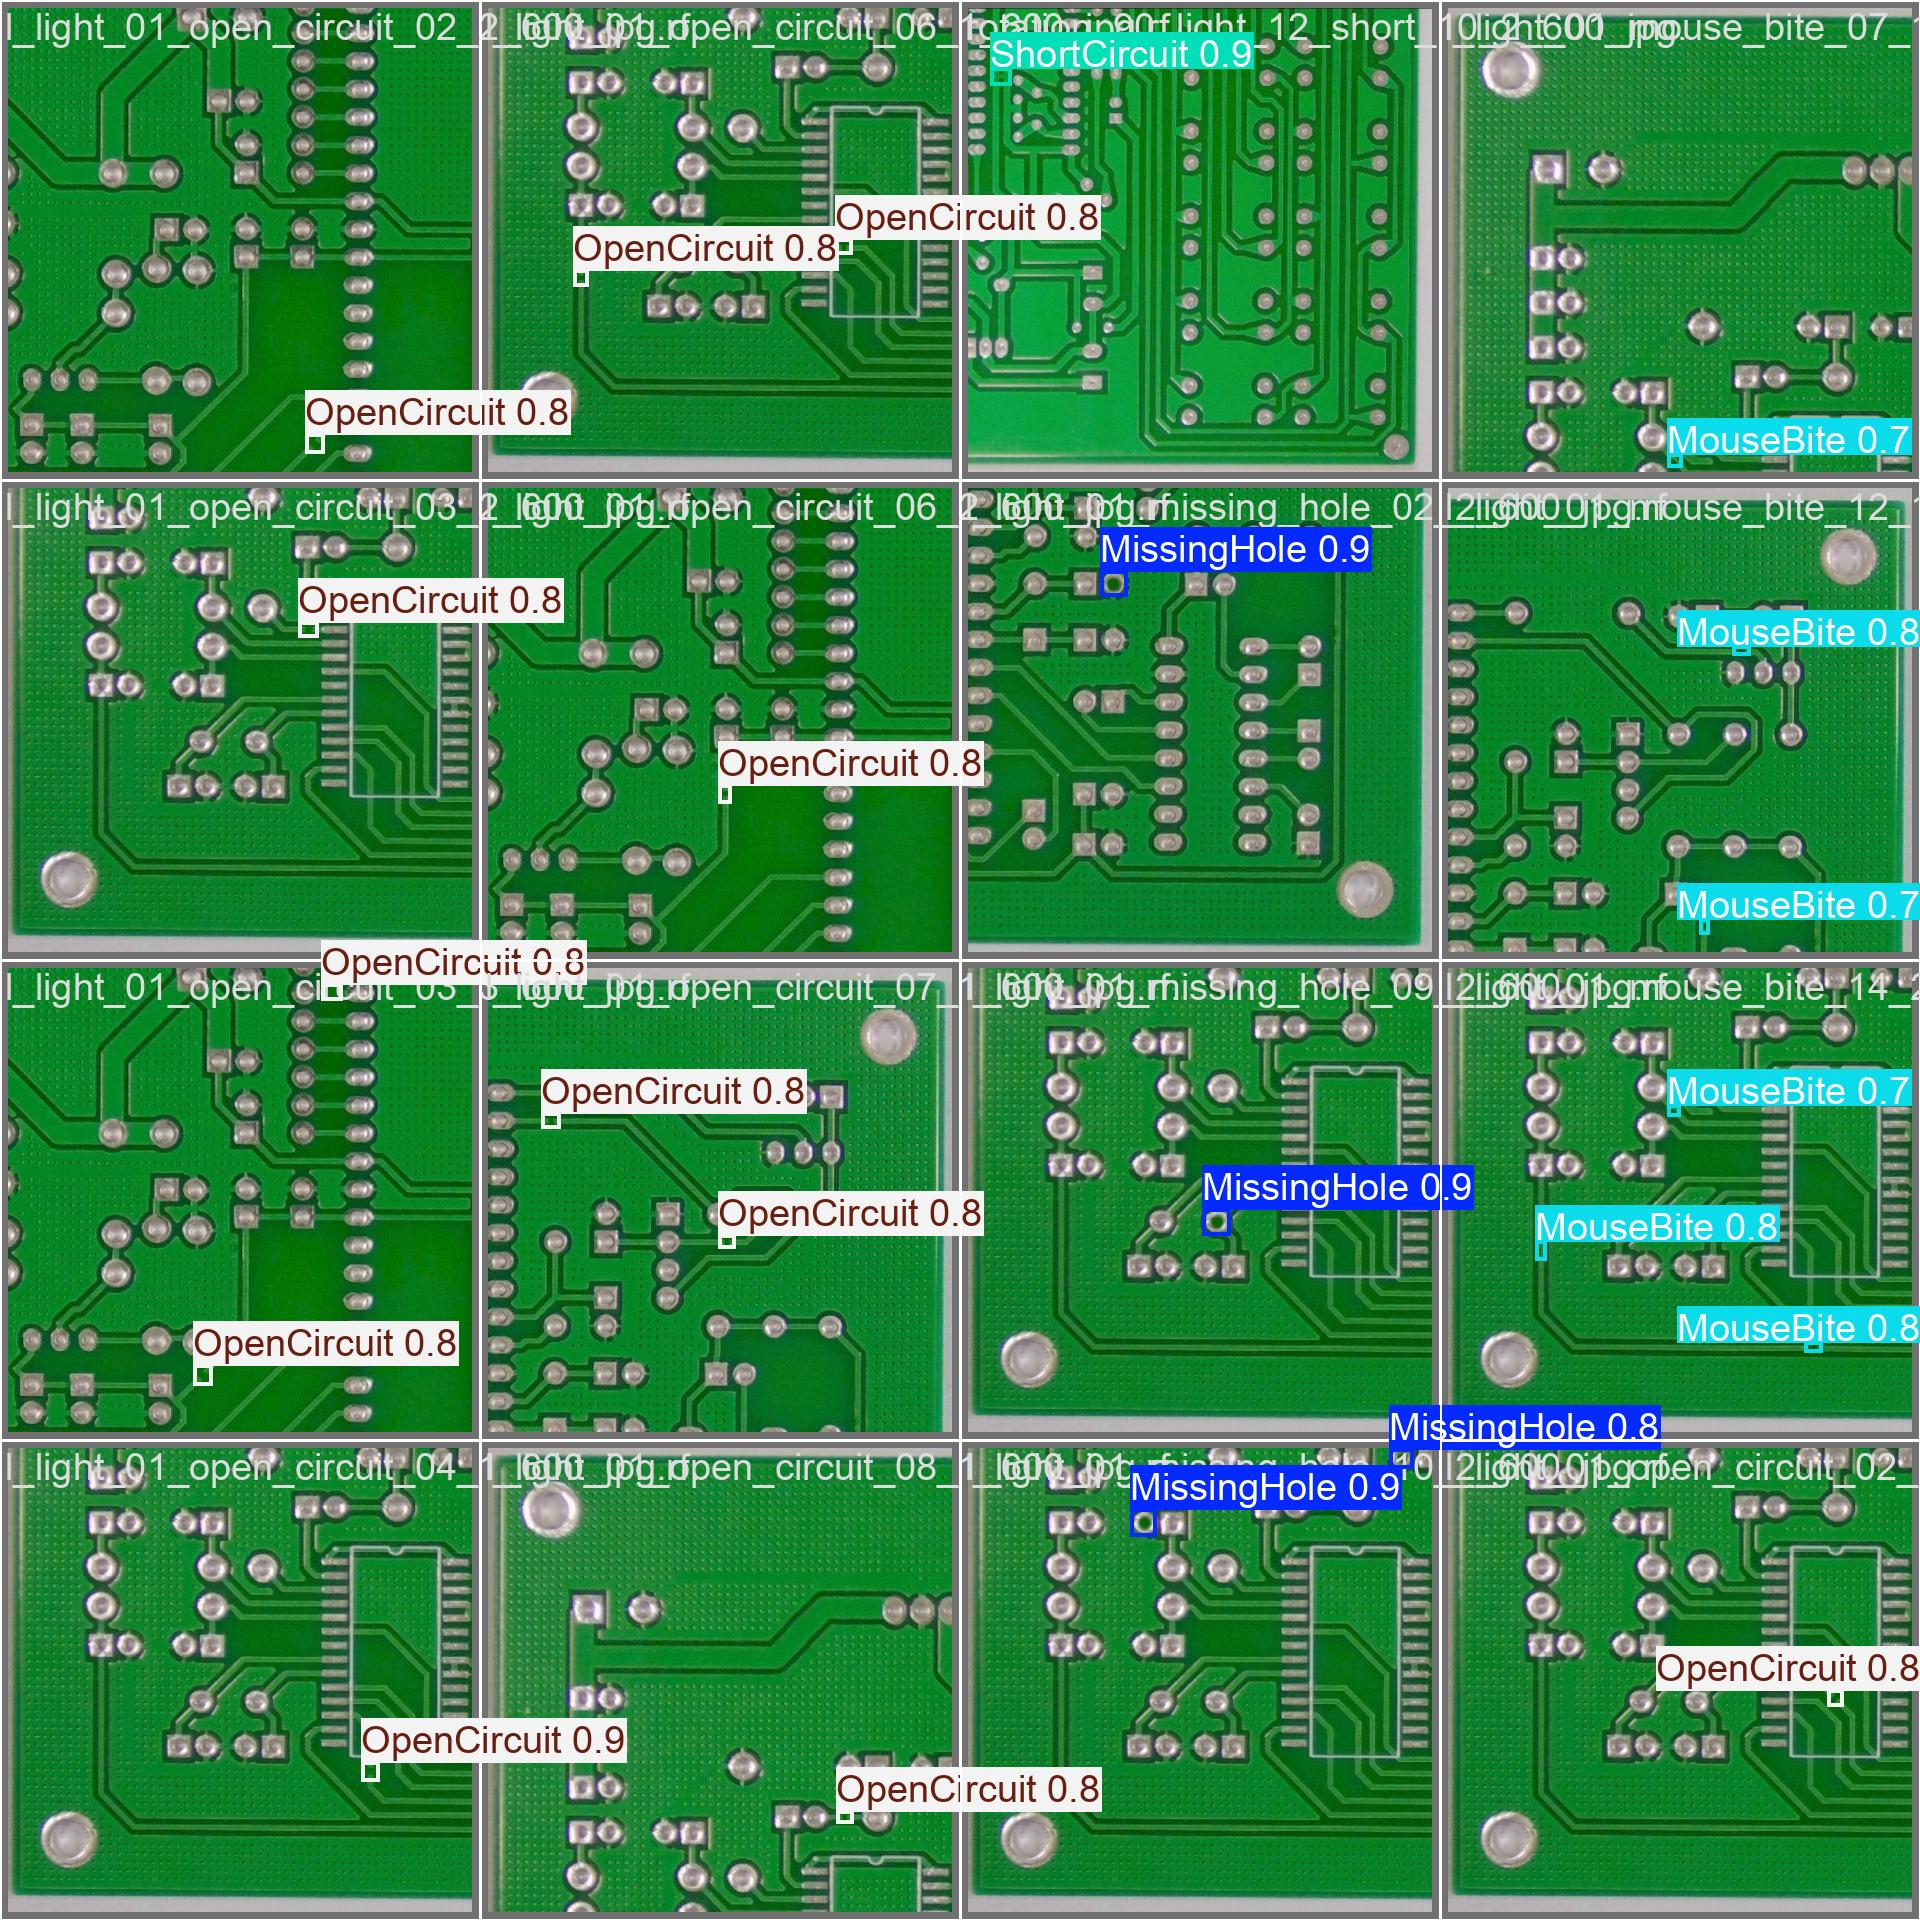

In [32]:
Image(filename=f'{HOME}/runs/detect/{NAME}/val_batch1_pred.jpg', width=600)